In [6]:
#rm -r *

In [7]:
# Uncomment the line below and run this cell to get your data from github into colab (only runnable in colab, not ordinary jupyter notebook):
#! git clone https://github.com/lkriener/music_generation.git && mv music_generation/* . && rm music_generation -r 

In [8]:
# Uncomment line to install requirements
#! pip install -r colab_requirements.txt

# Music generation using note-to-note LSTMs 
In this part, we will try to generate melodies from the same dataset (Bach Chorals) using recurrent neural networks (RNN) with long short term memory units (LSTM) as in the tutorial 08 of the class, based on the two following blog posts:

- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c

The idea would be to extend the character-to-character LSTM network to midi files. We will also use another representation of the data, namely 'pianorolls', where a single melody is stored in a matrix with the x-axis for time and the y-axis for the pitch. This is one of the most frequent representations used, although it has some limitations. For instance, there is no way to differentiate between a long note (1 half-note) and 4 short-ones (4 eight-notes). However, it brings a considerable advantage compared to the previous used representations as it can store rhythm, depending on the chosen time-step. 

Moreover, each possible note is considered as a distinct element of a vocabulary. We will then use $N$ input nodes, where $N$ is the size of the vocabulary (i.e., the number of distinct notes, including silences). 
Thus, these pianorolls arrays will be converted into one-hot vectors containing the corresponding pitch (or silence, represented by 0) for each time step, and will be fed to the RNN network defined below. 

## Test of pypianoroll library
We will first use the pypianoroll library - https://salu133445.github.io/pypianoroll/ - to convert a midi file into a multitrack object, get the soprano track, transpose it to C major, create a new multitrack object out of it, and finally write it to a new midi file. 

In [1]:

import pygame
from pypianoroll import Multitrack, Track
import pypianoroll
import os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
%pylab inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Populating the interactive namespace from numpy and matplotlib


In [2]:
from src.RNN_utils import *

No GPU available, training on CPU; consider making n_epochs very small.


In [3]:
try:
    home_dir
except NameError:
    home_dir = os.getcwd()

os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir

In [4]:
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
label_scaler = StandardScaler()

# iterate over all midi files of folder
import glob
import os
import numpy as np

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
    

In [5]:
# get lower and upper bounds 
voice = 0 
all_pianorolls, midi_files = get_all_pianorolls(voice, home_dir, beat_resolution=4)
global_lower, global_upper, n_notes = get_extremum_pitches([all_pianorolls])
print('Global lower note : '+ str(global_lower))
print('Global upper note : '+ str(global_upper))
print('Number of notes : '+ str(n_notes))

/Users/deperrois/Documents/BERN/ATML/myenv/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Global lower note : 57
Global upper note : 83
Number of notes : 28


In [6]:
print("Pianoroll sequence of soprano :")
print(all_pianorolls[0:100])

Pianoroll sequence of soprano :
[ 0  0  0  0 70 70 70  0 70 70 70 70 68 68 68 68 66 66 66 66 65 65 65 65
 65 65 65 65 63 63 63 63 63 63 63 63 70 70 70  0 70 70 70 70 72 72 72 72
 74 74 74 74 75 75 75 75 75 75 75 75 74 74 74 74 74 74 74 74 75 75 75 75
 78 78 78 78 77 77 77 77 77 77 75  0 75 75 75 75 75 75 75 75 75 75 75 75
 75 75 75 75]


In order to minimize the size of one-hot encode vectors, we restrict the pitches to values next to 0, using the minimum pitch found in the dataset. 

In [7]:
# scale pianoroll to 0 
print("Pianoroll sequence of soprano scaled to 0:")
all_pianorolls_scaled = scale_pianoroll(all_pianorolls, global_lower)
print(all_pianorolls_scaled[0:100])

Pianoroll sequence of soprano scaled to 0:
[ 0  0  0  0 14 14 14  0 14 14 14 14 12 12 12 12 10 10 10 10  9  9  9  9
  9  9  9  9  7  7  7  7  7  7  7  7 14 14 14  0 14 14 14 14 16 16 16 16
 18 18 18 18 19 19 19 19 19 19 19 19 18 18 18 18 18 18 18 18 19 19 19 19
 22 22 22 22 21 21 21 21 21 21 19  0 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19]


## Generation of a single voice

As a first attempt to generate a melody using LSTMs with pianorolls, we will simply try to generate a single voice (soprano, alto, tenor or bass), training the network on the whole midi file dataset concatenated into a long sequence of notes all translated to the same tonality (here, C Major or its relative A minor). The later operation will particularly facilitate learning on such a small dataset as all melodies will be rescaled to the same tonality, thus preventing abrupt changes among melody batches. 

In [8]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


### Define a LSTM network as for note-to-note melody generation
We now build a network to implement note-to-note melody generation using LSTMs units as well as drop-out of the output. This network is highly inspired from the Tutorial 08 of the class, by replacing characters by notes. 

For training the model, we declare a function, where we define an optimizer (Adam) and loss (cross entropy). Then, training and validation data are separated and the hidden state of the RNN is initaliazed. Looping over the training melody batches, we use the functions `get_pianoroll_batches` and `one_hot_encode_batch` in order to build batches and feed them to the network input. This function is also adapted to harmonization that will be defined below. 

Every once a while, we generate some loss statistics (training loss and validation loss) to let us know if the model is training correctly.

In [10]:
# Define and print the net
n_hidden=128
n_layers=3

net = NoteRNN(n_notes, n_hidden, n_layers)
print(net)

# Declaring the hyperparameters
batch_size = 64
seq_length = 50
n_epochs = 100 # start smaller if you are just testing initial behavior

# train the model
train_losses, val_losses, best_net, best_epoch = train(net, all_pianorolls_scaled, 
                                             epochs=n_epochs, batch_size=batch_size, 
                                             seq_length=seq_length, lr=0.001)

NoteRNN(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=128, out_features=28, bias=True)
)
Epoch: 10/100... Loss: 1.2116... Val Loss: 1.1692
Epoch: 20/100... Loss: 0.8740... Val Loss: 0.8569
Epoch: 30/100... Loss: 0.6489... Val Loss: 0.8111
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 40/100... Loss: 0.5960... Val Loss: 0.8987
Epoch: 50/100... Loss: 0.5637... Val Loss: 0.8939
Epoch: 60/100... Loss: 0.5387... Val Loss: 0.8750
Epoch: 70/100... Loss: 0.5162... Val Loss: 0.7881
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 80/100... Loss: 0.4931... Val Loss: 0.8409
Epoch: 90/100... Loss: 0.4715... Val Loss: 0.8865
Epoch: 100/100... Loss: 0.4469... Val Loss: 0.8984


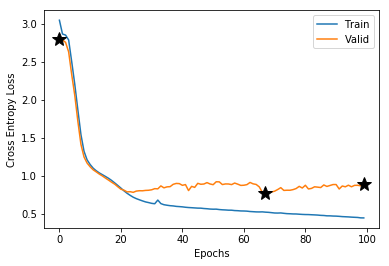

In [11]:
fig = figure(figsize(6,4))
ax = fig.add_subplot(1,1,1)
display_losses(ax, train_losses, val_losses, best_epoch)

### Test of the network: generation of single voice 
We will now test the trained network to predict potential melodies starting from a short sequence of notes. Here again, the functions `predict` and `sample` are highly inspired from the Tutorial 8, and slightly modified towards pianorolls data processing. 



The `NoteRNN` network outputs scaled pianorolls. We thus need to send back the obtained pitches to the associated voice range, using the function `unscale_pianoroll`. We then store the pianoroll to a track object, and to a multitrack object, which can directly be used to write a midi file. 

In [0]:
seq_size = 50
start = 73 - global_lower # starting with a C 

Let's first try melody generation with a random initial network (no training). 

In [0]:
random_net = NoteRNN(n_notes, n_hidden, n_layers)
multitrack_random = process_single(random_net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_random, home_dir + "/results/RNN_single_random")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_random.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

As expected, it does not sound like a Bach melody, as it is totally out of key. 
Let's now try it with the early-stopped network.

In [0]:
multitrack_early = process_single(best_net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_early, home_dir + "/results/RNN_single_early")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_early.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

Finally, we try to generate Bach melody with the overfitting network. 

In [0]:
multitrack_overfit = process_single(net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_overfit, home_dir + "/results/RNN_single_overfit")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_overfit.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

******* 
### Colab specific player 

In [16]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio



Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [17]:
modified_midi_filename = home_dir + "/results/RNN_single_random.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'single_random.wav')
Audio("single_random.wav")

Output hidden; open in https://colab.research.google.com to view.

In [18]:
modified_midi_filename = home_dir + "/results/RNN_single_early.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'single_early.wav')
Audio("single_early.wav")

Output hidden; open in https://colab.research.google.com to view.

In [19]:
modified_midi_filename = home_dir + "/results/RNN_single_overfit.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'single_overfit.wav')
Audio("single_overfit.wav")

Output hidden; open in https://colab.research.google.com to view.

**********
**********

## Train for harmonization

We observed above that it is possible to generate a coherent melody using a slightly modified version of the original character-to-character RNN. Here, we will investigate whether such a network can perform more complex task, such as harmonizing a given voice. For instance, from the soprano sequence, we would like to generate the associated alto voice. 

In [0]:
beat_resolution = 2

In [0]:

all_pianorolls_soprano,_ = get_all_pianorolls(0, home_dir, beat_resolution=beat_resolution)
all_pianorolls_alto,_ = get_all_pianorolls(1, home_dir, beat_resolution=beat_resolution)
all_pianorolls_tenor,_ = get_all_pianorolls(2, home_dir, beat_resolution=beat_resolution)
all_pianorolls_bass,_ = get_all_pianorolls(3, home_dir, beat_resolution=beat_resolution)

In [22]:
list_pianorolls = [all_pianorolls_soprano, all_pianorolls_alto, all_pianorolls_tenor, all_pianorolls_bass]
global_lower, global_upper, n_notes = get_extremum_pitches(list_pianorolls)


print('Global lower note : '+ str(global_lower))
print('Global upper note : '+ str(global_upper))
print('Number of notes : '+ str(n_notes))

Global lower note : 35
Global upper note : 83
Number of notes : 50


We now rescale the pianorolls to values next to 0. 

In [0]:
# scale pianoroll to 0 
all_pianorolls_soprano = scale_pianoroll(all_pianorolls_soprano, global_lower)
all_pianorolls_alto = scale_pianoroll(all_pianorolls_alto, global_lower)
all_pianorolls_tenor = scale_pianoroll(all_pianorolls_tenor, global_lower)
all_pianorolls_bass = scale_pianoroll(all_pianorolls_bass, global_lower)


It is now time to train the network to perform harmonization. Setting the mode to `"harmonization"`, we will call the function `get_pianoroll_batches_harmonization` that generates one-hot vectors of both input and target melodies. 

In [0]:
# Define and print the net
n_hidden=512
n_layers=2

net_alto = NoteRNN(n_notes, n_hidden, n_layers)
net_tenor = NoteRNN(n_notes, n_hidden, n_layers)
net_bass = NoteRNN(n_notes, n_hidden, n_layers)



# Declaring the hyperparameters
batch_size = 32
seq_length = 100
n_epochs = 200 # start smaller if you are just testing initial behavior

In [25]:
# train the model
train_losses_alto, val_losses_alto, best_net_alto, best_epoch_alto = train(net_alto, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_alto, mode="harmonization",
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.001)



Epoch: 10/200... Loss: 2.5048... Val Loss: 2.5027
Epoch: 20/200... Loss: 2.0161... Val Loss: 2.0895
Epoch: 30/200... Loss: 1.7936... Val Loss: 1.9334
Epoch: 40/200... Loss: 1.6710... Val Loss: 1.8601
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 50/200... Loss: 1.5466... Val Loss: 1.8371
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 60/200... Loss: 1.3873... Val Loss: 1.8459
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 70/200... Loss: 1.2186... Val Loss: 1.9282
Epoch: 80/200... Loss: 0.9642... Val Loss: 2.0963
Epoch: 90/200... Loss: 0.7395... Val Loss: 2.2558
Epoch: 100/200... Loss: 0.5450... Val Loss: 2.4153
Epoch: 110/200... Loss: 0.3389... Val Loss: 2.7492
Epoch: 120/200... Loss: 0.2464... Val Loss: 2.9552
Epoch: 130/200... Loss: 0.1910... Val Loss: 3.2169
Epoch: 140/200... Loss: 0.0929... Val Loss: 3.3734
Epoch: 150/200... Loss: 0.0664... Val Loss: 3.6077
Epoch: 160/200... Loss: 0.0996... Val Loss: 3.5401
E

In [26]:
# train the model
train_losses_tenor, val_losses_tenor, best_net_tenor, best_epoch_tenor = train(net_tenor, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_tenor, mode="harmonization",
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.001)

Epoch: 10/200... Loss: 2.4853... Val Loss: 2.4582
Epoch: 20/200... Loss: 2.0745... Val Loss: 2.0842
Epoch: 30/200... Loss: 1.8164... Val Loss: 1.9478
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 40/200... Loss: 1.6587... Val Loss: 1.9296
Epoch: 50/200... Loss: 1.4332... Val Loss: 1.9948
Epoch: 60/200... Loss: 1.1630... Val Loss: 2.1088
Epoch: 70/200... Loss: 0.8262... Val Loss: 2.3843
Epoch: 80/200... Loss: 0.5616... Val Loss: 2.7166
Epoch: 90/200... Loss: 0.4291... Val Loss: 2.9401
Epoch: 100/200... Loss: 0.2435... Val Loss: 3.3092
Epoch: 110/200... Loss: 0.1377... Val Loss: 3.6585
Epoch: 120/200... Loss: 0.1084... Val Loss: 3.9268
Epoch: 130/200... Loss: 0.1146... Val Loss: 4.0366
Epoch: 140/200... Loss: 0.1207... Val Loss: 4.0011
Epoch: 150/200... Loss: 0.0472... Val Loss: 4.3624
Epoch: 160/200... Loss: 0.0351... Val Loss: 4.5388
Epoch: 170/200... Loss: 0.0575... Val Loss: 4.5956
Epoch: 180/200... Loss: 0.0688... Val Loss: 4.6914
Epoch: 190/200... Loss: 0.0

In [27]:
# train the model
train_losses_bass, val_losses_bass, best_net_bass, best_epoch_bass = train(net_bass, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_bass, mode="harmonization",
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.001)

Epoch: 10/200... Loss: 2.7599... Val Loss: 2.8274
Epoch: 20/200... Loss: 2.5178... Val Loss: 2.5590
Epoch: 30/200... Loss: 2.1431... Val Loss: 2.2434
Epoch: 40/200... Loss: 1.9073... Val Loss: 2.1075
Epoch: 50/200... Loss: 1.6104... Val Loss: 2.1407
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 60/200... Loss: 1.2369... Val Loss: 2.2365
Epoch: 70/200... Loss: 0.9117... Val Loss: 2.3979
Epoch: 80/200... Loss: 0.6142... Val Loss: 2.6906
Epoch: 90/200... Loss: 0.3626... Val Loss: 2.9884
Epoch: 100/200... Loss: 0.2686... Val Loss: 3.2228
Epoch: 110/200... Loss: 0.2233... Val Loss: 3.4859
Epoch: 120/200... Loss: 0.1331... Val Loss: 3.6704
Epoch: 130/200... Loss: 0.1102... Val Loss: 3.8604
Epoch: 140/200... Loss: 0.0670... Val Loss: 3.9899
Epoch: 150/200... Loss: 0.0531... Val Loss: 4.1239
Epoch: 160/200... Loss: 0.1586... Val Loss: 4.0998
Epoch: 170/200... Loss: 0.0805... Val Loss: 3.9605
Epoch: 180/200... Loss: 0.0381... Val Loss: 4.2956
Epoch: 190/200... Loss: 0.0

### Losses evolution with training and overfitting 
Now that our 3 networks are trained, we will inspect how the losses evolve with harmonization for each of the generated voices. 

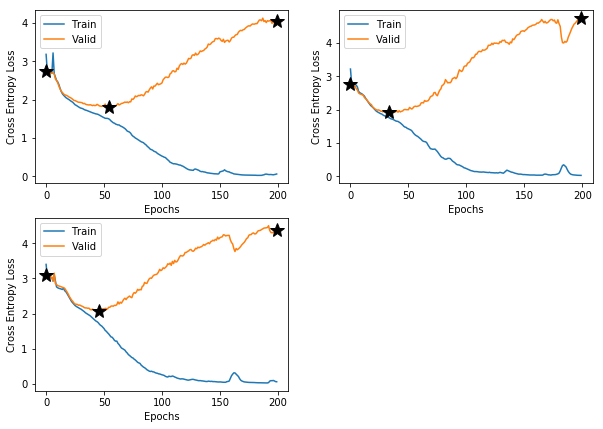

In [28]:
fig = figure(figsize(10,7))
ax1 = fig.add_subplot(2,2,1)
display_losses(ax1, train_losses_alto, val_losses_alto, best_epoch_alto)
ax2 = fig.add_subplot(2,2,2)
display_losses(ax2, train_losses_tenor, val_losses_tenor, best_epoch_tenor)
ax3 = fig.add_subplot(2,2,3)
display_losses(ax3, train_losses_bass, val_losses_bass, best_epoch_bass)

### Test of harmonization from a soprano track

It is now time to test the quality of the RNNs trained to harmonize a soprano voice by generating separately alto, tenor and bass voices. We will test it on one given bach midi file in the browser. 

In [61]:
 # Generating harmonization

os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir
# get one voice from the dataset 
#midi_filename = 'bwv368.mid'
midi_filename = midi_files[-5]
print("Let's generate alto, tenor and bass from "+ midi_filename + " soprano")
#midi_filename = 'pkgsc_azalea.mid'

real_tracks = []
for voice in range(4):
    track = get_track(midi_filename, voice, beat_resolution=beat_resolution, transpose=True)
    real_tracks.append(track)

Let's generate alto, tenor and bass from bwv278.mid soprano


Let's first generate harmonization with a ramdom initial network, without training. 

In [0]:
random_net_alto = NoteRNN(n_notes, n_hidden, n_layers)
random_net_tenor = NoteRNN(n_notes, n_hidden, n_layers)
random_net_bass = NoteRNN(n_notes, n_hidden, n_layers)

random_networks = [None, random_net_alto, random_net_tenor, random_net_bass]
generated_tracks_random = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, random_networks, 
                                            global_lower, real_tracks, voice_togenerate)
    generated_tracks_random.append(generated_track)
    
multitrack_random = Multitrack(tracks=generated_tracks_random, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_random, home_dir + "/results/RNN_harmonization_random")

In [63]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_random.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [0]:
pygame.mixer.music.stop()

As expected, the harmonization is totally random, thus all voices are not following the soprano melody and generate random melodies independently. d
Let's now test the quality of harmonization for the non-overfitting early-stopped networks.  

In [0]:
best_networks = [None, best_net_alto, best_net_tenor, best_net_bass]

# Early stopped network test 
generated_tracks_early = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, best_networks, 
                                            global_lower, real_tracks, voice_togenerate)
    generated_tracks_early.append(generated_track)
    
multitrack_early = Multitrack(tracks=generated_tracks_early, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_early, home_dir + "/results/RNN_harmonization_early")

In [50]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_early.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [51]:
pygame.mixer.music.stop()

error: ignored

The obtained track sounds much better and start to harmonize the soprano voice correctly, especially by trying to match the soprano rhythm. However, it is not optimal as we cannot hear any coherent harmonies and cadences. 
Let's finally try on the highly-overfitting network. 

In [0]:
networks = [None, net_alto, net_tenor, net_bass]

# Overfitting network test 
generated_tracks_overfit = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, networks, 
                                            global_lower, real_tracks, voice_togenerate)
    generated_tracks_overfit.append(generated_track)
multitrack_overfit = Multitrack(tracks=generated_tracks_overfit, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_overfit, home_dir + "/results/RNN_harmonization_overfit")    

In [53]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_overfit.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [54]:
pygame.mixer.music.stop()

error: ignored

The overfitting networks sounds to generate voices that match much better with the soprano voice than the previous networks! Even if at the beginning, the voices are not really coherent, they start to catch some relevant melodies that vertically harmonize the soprano voice. 
We hypothesize that such surprising results might be specific to music generation. Bach Chorales are quite similar, especially when transcripted to C Major (or its relative A minor), and overfitting the training set can lead to optimal network features to generate 3 voices on a soprano voice which harmonization was never learned (validation set). Even if the validation error is huge compared to the early stopping case, it does not mean that the generated voices are wrong. The overfitted network generate complete different alto/tenor/bass melodies from the original ones, which might explain this huge validation error, but these melodies vertically compose different chords and cadences that can turn out to be really coherent! 
As an example, think of the original track ending up with an interrupted cadence, in a total different tonality than C Major (let's say, A Major), which has been seen less often that a perfect cadence (C Major) in the training set. The overfitting network will unless try to recover this perfect cadence as it learned to do by overfitting, and thus generate complete different melodies than the target ones, but vertically coherent with each other to produce such a perfect cadence! 

As an illustration of such a phenomenon, let's listen to original track (real alto/tenor/bass voices) and compare to the overfitted track at the same time steps. 

In [0]:
# Real track 
multitrack_real = Multitrack(tracks=real_tracks, tempo = 90, beat_resolution=beat_resolution)
# write to midifile 
pypianoroll.write(multitrack_real, home_dir + "/results/RNN_harmonization_real")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_real.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()


*********
### Colab specific player code 

In [55]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_random.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'harmonization_random.wav')
Audio("harmonization_random.wav")

Output hidden; open in https://colab.research.google.com to view.

In [56]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_early.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'harmonization_early.wav')
Audio("harmonization_early.wav")

Output hidden; open in https://colab.research.google.com to view.

In [67]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_overfit.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'harmonization_overfit.wav')
Audio("harmonization_overfit.wav")

Output hidden; open in https://colab.research.google.com to view.

In [68]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_real.mid"
FluidSynth("font.sf2").midi_to_audio(modified_midi_filename, 'harmonization_real.wav')
Audio("harmonization_real.wav")

Output hidden; open in https://colab.research.google.com to view.